## Data preparation

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv('./datasets/calories.csv')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [4]:
df=df.drop('User_ID',axis=1)

In [7]:
# Missing values
print(df.isnull().sum())

Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


In [8]:
# Normalisation
num_cols=df.columns.to_list()[1:]

for col in num_cols:
    df[col]=df[col]-np.mean(df[col],axis=0)
df.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,25.2102,15.534867,19.033133,13.4694,9.481467,0.774547,141.460467
1,female,-22.7898,-8.465133,-14.966867,-1.5306,-1.518533,0.274547,-23.539533
2,male,26.2102,4.534867,4.033133,-10.5306,-7.518533,-1.325453,-63.539533
3,female,-8.7898,4.534867,-3.966867,-2.5306,4.481467,0.474547,-18.539533
4,female,-15.7898,-20.465133,-16.966867,-5.5306,-14.518533,-0.225453,-54.539533


In [12]:
# Encoding
df["Gender"]=pd.get_dummies(df["Gender"],drop_first=True)
df["Gender"].to_frame().head()

,Gender
0,True
1,False
2,True
3,False
4,False


> **Data preparation**
1. Normalisation for numerical columns: 
    * Age
    * Height
    * Weight
    * Duration
    * Heart_Rate
    * Body_Temp
2. Dummy encoding for Gender categorical column
    * Male = True
    * Female = False

In [9]:
# Splitting data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df.drop('Calories',axis=1),df['Calories'],random_state=42,test_size=0.2)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((12000, 7), (12000,), (3000, 7), (3000,))

## Using confidence intervals

In [2]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.utils import resample

In [ ]:
metrics=[]

def display_results(model_pred,target_test,lower_bound,upper_bound):

    results=pd.DataFrame({
    "Actual": target_test.values,
    'Predicted':model_pred,
    "Upper bound": upper_bound,
    'Lower bound': lower_bound
    })
    print(results.head())

    plt.figure(figsize=(12,6))
    plt.plot(model_pred[:50], 'ro-', label='Model prediction')
    plt.plot(target_test.values[:50], 'bo-', label='Actual values')
    plt.fill_between(
        np.arange(50),
        lower_bound[:50], 
        upper_bound[:50], 
        color='gray', alpha=0.5, label='Confidence interval')
    plt.legend()
    plt.show()

#### Linear regression

           Actual   Predicted  Upper bound  Lower bound
11499   83.460467   81.136927   103.235119    59.038735
6475    99.460467  102.549045   124.651982    80.446108
13167  -36.539533  -33.391569   -11.293449   -55.489690
862     71.460467   65.936881    88.035051    43.838712
5970   136.460467  122.911133   145.013372   100.808895


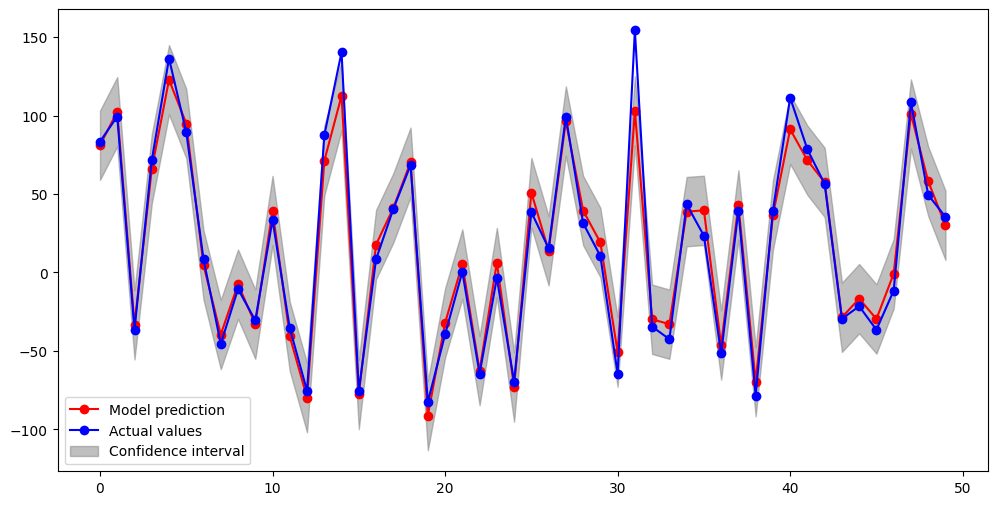

In [ ]:
lin_reg=LinearRegression()
lin_reg.fit(x_train,y_train)
lin_reg_pred=lin_reg.predict(x_test)

x_train["Gender"]=x_train['Gender'].astype(int)
x_test["Gender"]=x_test['Gender'].astype(int)

x_train_sm=sm.add_constant(x_train)
x_test_sm=sm.add_constant(x_test)

ols_model=sm.OLS(y_train,x_train_sm).fit()
ols_pred=ols_model.get_prediction(x_test_sm)
ols_summary=ols_pred.summary_frame(alpha=0.05)

metrics.append({
    'Name': 'Linear regression',
    'MAE': mean_absolute_error(lin_reg_pred,y_test),
    'RMSE': root_mean_squared_error(lin_reg_pred,y_test),
    'R2': r2_score(lin_reg_pred,y_test)
})

display_results(lin_reg_pred,y_test,ols_summary['obs_ci_lower'],ols_summary['obs_ci_upper'])

#### Lasso

       Actual   Predicted  Upper bound  Lower bound
0   83.460467   78.344481   101.362332    55.326631
1   99.460467   95.542271   118.560121    72.524420
2  -36.539533  -29.153603    -6.135753   -52.171454
3   71.460467   65.603032    88.620882    42.585181
4  136.460467  122.459821   145.477672    99.441971


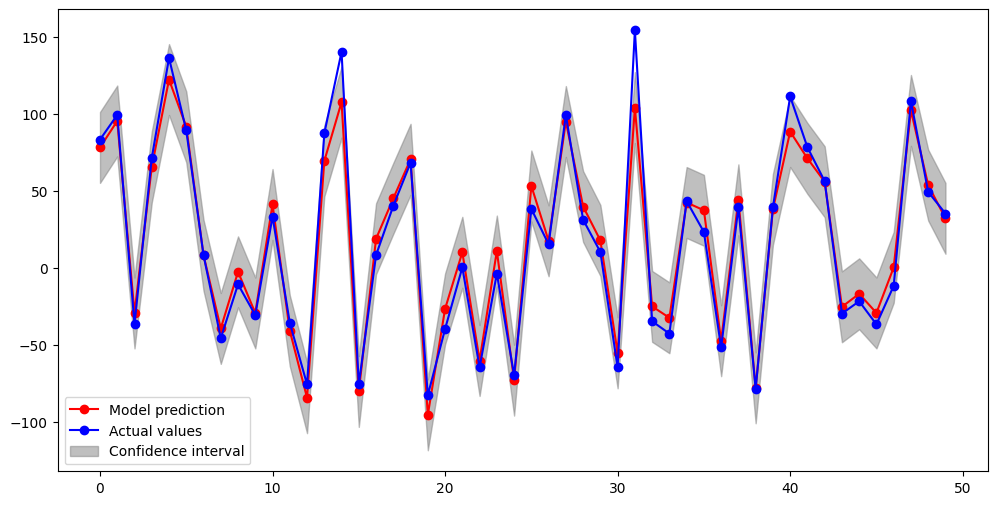

In [ ]:
lasso_model=Lasso(alpha=1.0)
lasso_model.fit(x_train,y_train)
lasso_pred=lasso_model.predict(x_test)

residuals=y_train-lasso_model.predict(x_train)
sigma=np.std(residuals)
lasso_lower=lasso_pred-1.96*sigma
lasso_upper=lasso_pred+1.96*sigma

metrics.append({
    'Name': 'Lasso',
    'MAE': mean_absolute_error(lasso_pred,y_test),
    'RMSE': root_mean_squared_error(lasso_pred,y_test),
    'R2': r2_score(lasso_pred,y_test)
})

display_results(lasso_pred,y_test,lasso_lower,lasso_upper)

#### Ridge

       Actual   Predicted  Upper bound  Lower bound
0   83.460467   81.132999   103.216367    59.049631
1   99.460467  102.540211   124.623579    80.456842
2  -36.539533  -33.386249   -11.302881   -55.469617
3   71.460467   65.937568    88.020937    43.854200
4  136.460467  122.910025   144.993393   100.826656


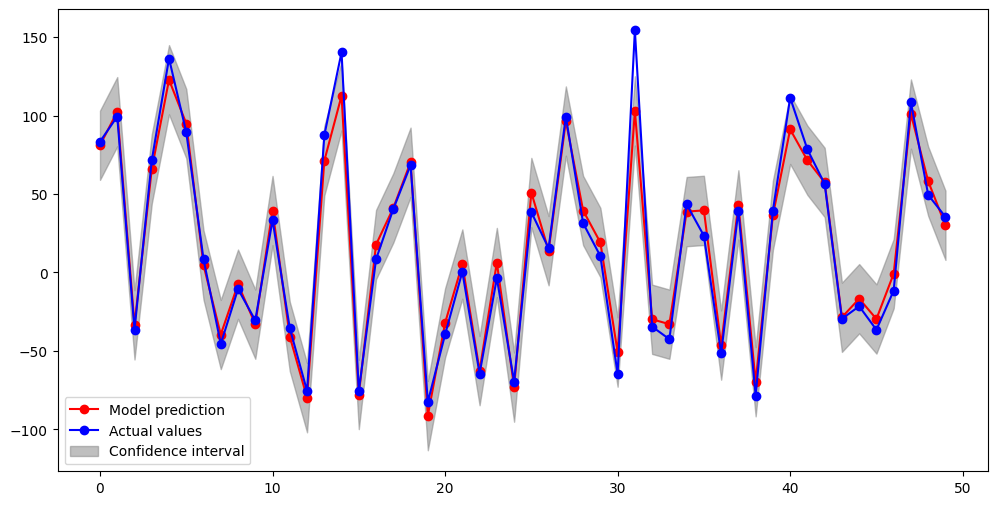

In [ ]:
ridge_model=Ridge(alpha=1.0)
ridge_model.fit(x_train,y_train)
ridge_pred=ridge_model.predict(x_test)

residuals=y_train-ridge_model.predict(x_train)
sigma=np.std(residuals)
ridge_lower=ridge_pred-1.96*sigma
ridge_upper=ridge_pred+1.96*sigma

metrics.append({
    'Name': 'Ridge',
    'MAE': mean_absolute_error(ridge_pred,y_test),
    'RMSE': root_mean_squared_error(ridge_pred,y_test),
    'R2': r2_score(ridge_pred,y_test)
})

display_results(ridge_pred,y_test,ridge_lower,ridge_upper)

#### Elastic net

       Actual   Predicted  Upper bound  Lower bound
0   83.460467   76.374888   100.604477    52.145298
1   99.460467   91.813871   116.043461    67.584281
2  -36.539533  -27.186907    -2.957317   -51.416496
3   71.460467   66.212033    90.441623    41.982444
4  136.460467  121.818792   146.048382    97.589203


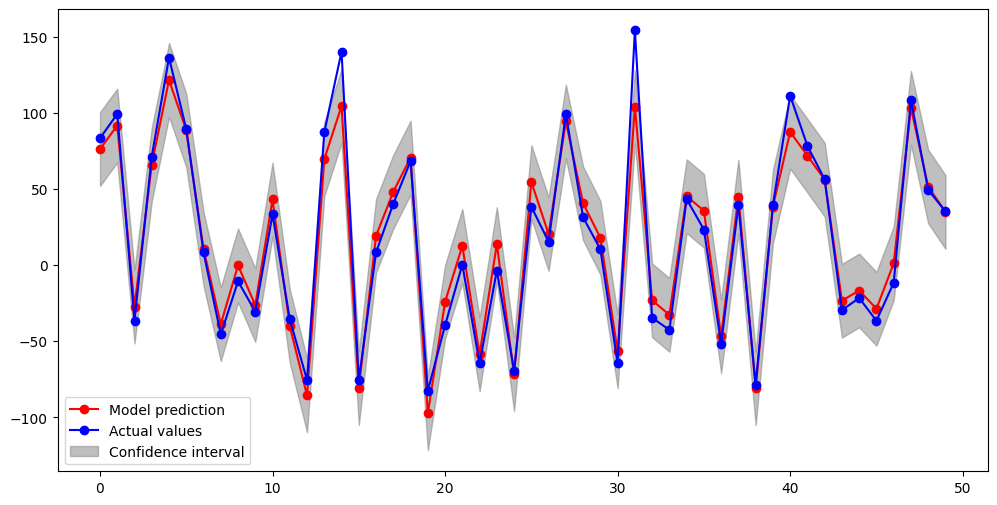

In [ ]:
elastic_model=ElasticNet(alpha=1.0)
elastic_model.fit(x_train,y_train)
elastic_pred=elastic_model.predict(x_test)

residuals=y_train-elastic_model.predict(x_train)
sigma=np.std(residuals)
elastic_lower=elastic_pred-1.96*sigma
elastic_upper=elastic_pred+1.96*sigma

metrics.append({
    'Name': 'Elastic',
    'MAE': mean_absolute_error(elastic_pred,y_test),
    'RMSE': root_mean_squared_error(elastic_pred,y_test),
    'R2': r2_score(elastic_pred,y_test)
})

display_results(elastic_pred,y_test,elastic_lower,elastic_upper)

#### Decision tree

       Actual   Predicted  Upper bound  Lower bound
0   83.460467   79.460467    90.460467    70.885467
1   99.460467  104.460467   119.035467    87.360467
2  -36.539533  -37.539533   -31.539533   -40.539533
3   71.460467   69.460467    87.135467    62.460467
4  136.460467  131.460467   141.460467   116.410467


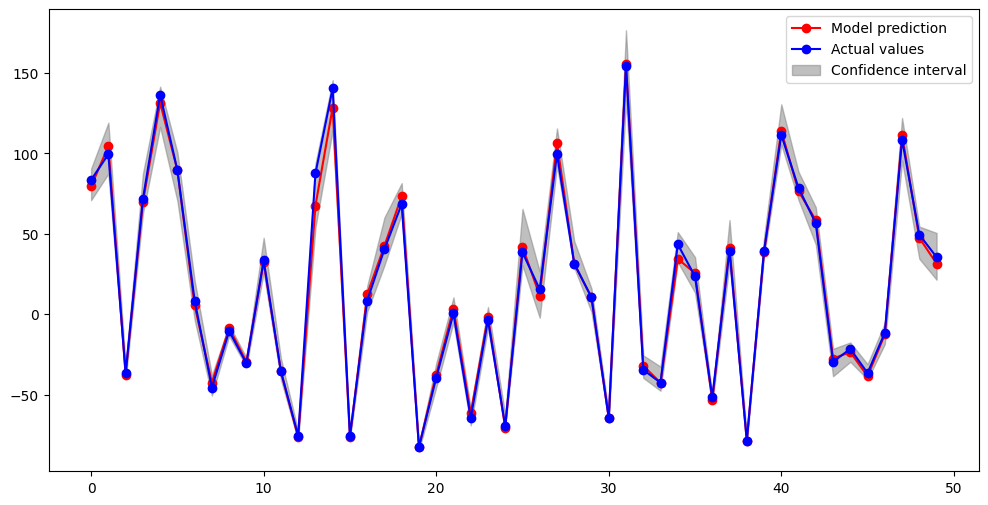

In [ ]:
n_bootstarps=100
bootstrap_preds=[]
for _ in range(n_bootstarps):
    x_res,y_res=resample(x_train,y_train)
    tree=DecisionTreeRegressor()
    tree.fit(x_res,y_res)
    bootstrap_preds.append(tree.predict(x_test))
bootstrap_preds=np.array(bootstrap_preds)

lower_bound=np.percentile(bootstrap_preds,2.5,axis=0)
upper_bound=np.percentile(bootstrap_preds,97.5,axis=0)
median_bound=np.median(bootstrap_preds,axis=0)

metrics.append({
    'Name': 'Decision tree',
    'MAE': mean_absolute_error(median_bound,y_test),
    'RMSE': root_mean_squared_error(median_bound,y_test),
    'R2': r2_score(median_bound,y_test)
})

display_results(median_bound,y_test,lower_bound,upper_bound)

#### Metrics

In [22]:
pd.DataFrame(metrics)

,Name,MAE,RMSE,R2
0,Linear regression,8.441514,11.488940,0.965804
1,Lasso,8.865121,11.992785,0.962307
2,Ridge,8.441412,11.488962,0.965803
3,Elastic,9.438367,12.624629,0.957881
4,Decision tree,2.054500,3.204801,0.997426


### Hyperparameters tuning

I dont want to do hyperparameters tuning for Linear regression, Lasso, Ridge, Elastic-Net, because they have similar metrics, and dont have much hyperparamters to tune

In [23]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model=DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10],  
    'max_features': ['sqrt', 'log2', None], 
    'max_leaf_nodes': [None, 10, 50, 100], 
}

grid=GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=10,
    n_jobs=9
)
grid.fit(x_train,y_train)
print(f'Best hyperparameters: {grid.best_params_}')

Best hyperparameters: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [25]:
tree_pred=grid.predict(x_test)
metrics.append({
    'Name': 'Tuned decision tree',
    'MAE': mean_absolute_error(tree_pred,y_test),
    'RMSE': root_mean_squared_error(tree_pred,y_test),
    'R2': r2_score(tree_pred,y_test)
})
pd.DataFrame(metrics)

,Name,MAE,RMSE,R2
0,Linear regression,8.441514,11.488940,0.965804
1,Lasso,8.865121,11.992785,0.962307
2,Ridge,8.441412,11.488962,0.965803
3,Elastic,9.438367,12.624629,0.957881
4,Decision tree,2.054500,3.204801,0.997426
5,Tuned decision tree,3.343944,5.069602,0.993617


> **Conclusion** <br><br>
`Decision tree regressor` looks like best model, also without tuning, because default parameters seem as good choise. <br>
All four linear models (linear, lasso, ridge, elastic-net) have really similar metrics, and all of them are good, so i think with current dataset all four are good choise, so you can choose one of them. <br>
But decision tree is much better in terms of metrics. 

## Using ensemble models

In [ ]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,StackingRegressor
from xgboost import XGBRFRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings("ignore")

### Bagging

MAE: 1.709819999999999
RMSE: 2.673833876664734
R2 score: 0.9982081040157473
       Actual   Predicted  Upper bound  Lower bound
0   83.460467   81.260467    91.460467    61.460467
1   99.460467  103.110467   135.460467    78.460467
2  -36.539533  -36.109533   -31.539533   -40.539533
3   71.460467   69.820467    92.460467    54.460467
4  136.460467  131.240467   148.460467   115.460467


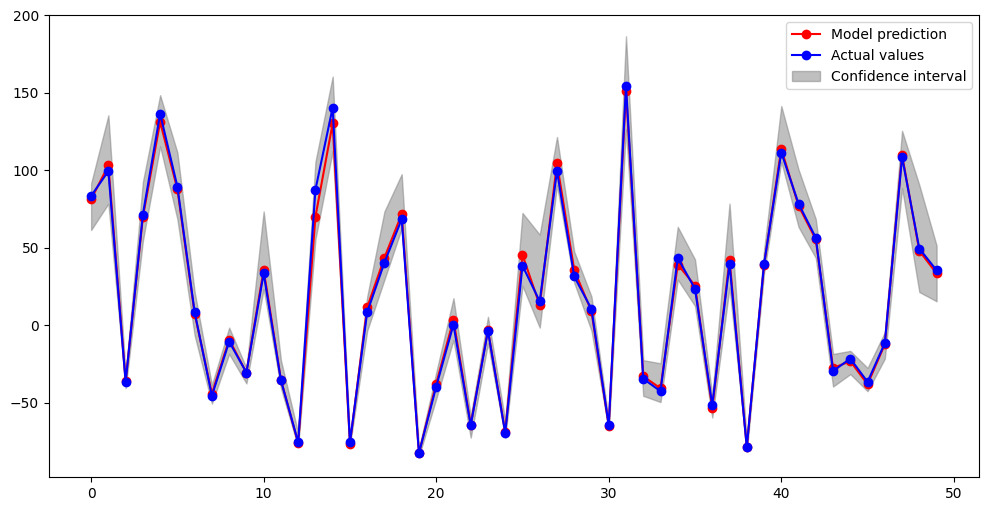

In [ ]:
forest_model=RandomForestRegressor(n_estimators=100,random_state=42)
forest_model.fit(x_train,y_train)
forest_pred=forest_model.predict(x_test)

print(f'MAE: {mean_absolute_error(forest_pred,y_test)}{'\n'}RMSE: {root_mean_squared_error(forest_pred,y_test)}{'\n'}R2 score: {r2_score(forest_pred,y_test)}')

forest_preds=np.array([model.predict(x_test) for model in forest_model.estimators_]).T
forest_min=forest_preds.min(axis=1)
forest_max=forest_preds.max(axis=1)

display_results(forest_pred,y_test,forest_min,forest_max)

### Boosting

MAE: 2.6055469715993396
RMSE: 3.612132078825044
R2 score: 0.9967379793489624
       Actual   Predicted  Upper bound  Lower bound
0   83.460467   80.852962    86.075790    18.922570
1   99.460467  104.019992   115.118126    11.141747
2  -36.539533  -38.638247   -31.863526   -45.565094
3   71.460467   73.666032    81.953846    15.893319
4  136.460467  133.717099   141.640783    18.922570


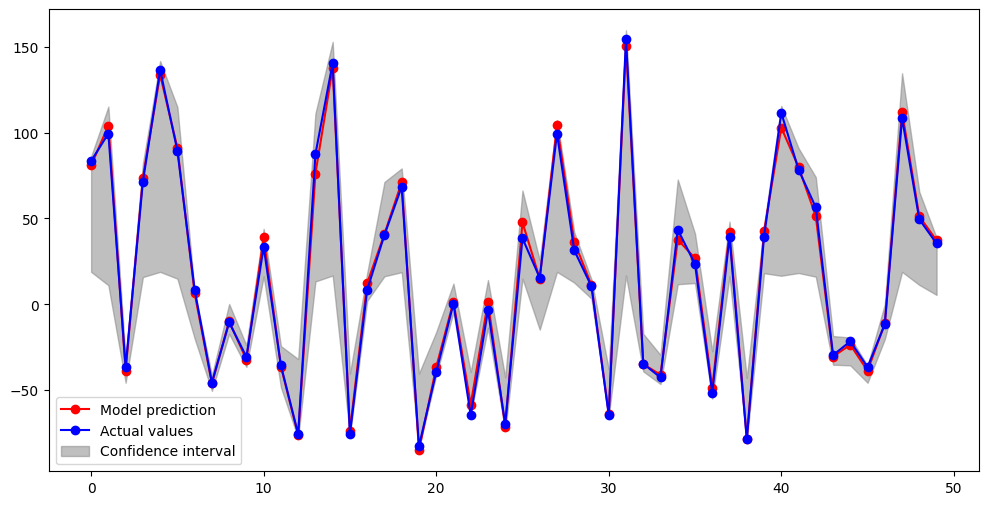

In [ ]:
gbr_model=GradientBoostingRegressor(random_state=42)
gbr_model.fit(x_train,y_train)
gbr_pred=gbr_model.predict(x_test)

gbr_lower=GradientBoostingRegressor(random_state=42,alpha=0.025,loss='quantile')
gbr_lower.fit(x_train,y_train)
gbr_pred_lower=gbr_lower.predict(x_test)

gbr_upper=GradientBoostingRegressor(random_state=42,alpha=0.975,loss='quantile')
gbr_upper.fit(x_train,y_train)
gbr_pred_upper=gbr_upper.predict(x_test)

print(f'MAE: {mean_absolute_error(gbr_pred,y_test)}{'\n'}RMSE: {root_mean_squared_error(gbr_pred,y_test)}{'\n'}R2 score: {r2_score(gbr_pred,y_test)}')

display_results(gbr_pred,y_test,gbr_pred_lower,gbr_pred_upper)

MAE: 5.017669517473745
RMSE: 7.412394803199899
R2 score: 0.985678081132947
       Actual   Predicted  Upper bound  Lower bound
0   83.460467   78.921982    85.820999    74.036537
1   99.460467  109.974152   114.576622   105.384247
2  -36.539533  -35.467194   -32.977669   -38.136471
3   71.460467   71.528549    78.144440    63.953728
4  136.460467  122.127090   125.395645   118.353149


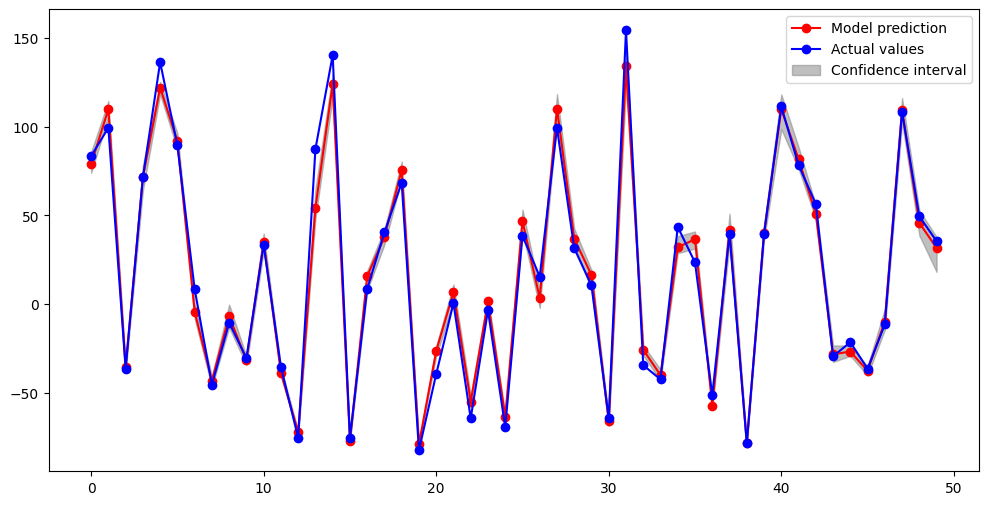

In [ ]:
n_bootstarps=100
xgb_preds=[]
for _ in range(n_bootstarps):
    xgb_model=XGBRFRegressor()
    x_res,y_res=resample(x_train,y_train)
    xgb_model.fit(x_res,y_res)
    xgb_pred=xgb_model.predict(x_test)
    xgb_preds.append(xgb_pred)
xgb_preds=np.array(xgb_preds)

xgb_lower=np.percentile(xgb_preds,2.5,axis=0)
xgb_upper=np.percentile(xgb_preds,97.5,axis=0)
xgb_median=np.median(xgb_preds,axis=0)

print(f'MAE: {mean_absolute_error(xgb_median,y_test)}{'\n'}RMSE: {root_mean_squared_error(xgb_median,y_test)}{'\n'}R2 score: {r2_score(xgb_median,y_test)}')

display_results(xgb_median,y_test,xgb_lower,xgb_upper)

### Stacking

In [ ]:
models=[
    ('tree',DecisionTreeRegressor(random_state=42)),
    ('svr',SVR()),
    ('lasso',Lasso(random_state=42))
]
meta_model=ElasticNet(random_state=42)

stacked_models=StackingRegressor(estimators=models,final_estimator=meta_model)
stacked_models.fit(x_train,y_train)
stacked_pred=stacked_models.predict(x_test)

print(f'MAE: {mean_absolute_error(stacked_pred,y_test)}{'\n'}RMSE: {root_mean_squared_error(stacked_pred,y_test)}{'\n'}R2 score: {r2_score(stacked_pred,y_test)}')

MAE: 2.9968400576739125
RMSE: 4.541008975080853
R2 score: 0.9949045395604735


## Turning regression into classification with different numbers of classes

In [31]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score

In [ ]:
def classification_results(model_pred,target_test,model_name):
    print(model_name)
    print(f'Accuracy: {accuracy_score(target_test,model_pred):.4f}')
    print(f'Accuracy: {precision_score(target_test,model_pred,average='weighted'):.4f}')
    print(f'Accuracy: {recall_score(target_test,model_pred,average='weighted'):.4f}')
    print(f'Accuracy: {f1_score(target_test,model_pred,average='weighted'):.4f}')
    print(confusion_matrix(target_test,model_pred))
    print()

### Four bins

In [ ]:
n_bins=4
kbd=KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy='uniform')
y_train_class=kbd.fit_transform(y_train.values.reshape(-1,1)).astype(int).ravel()
y_test_class=kbd.fit_transform(y_test.values.reshape(-1,1)).astype(int).ravel()
print(f'Distribution of discreted data: {'\n'}{pd.Series(y_train_class).value_counts()}')

Distribution of discreted data: 
0    6072
1    3867
2    1936
3     125
Name: count, dtype: int64


In [ ]:
log_reg=LogisticRegression(max_iter=5000,random_state=42)
log_reg.fit(x_train,y_train_class)
log_reg_pred=log_reg.predict(x_test)

decision_tree=DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train,y_train_class)
decision_tree_pred=decision_tree.predict(x_test)

xgb_model=XGBClassifier(random_state=42)
xgb_model.fit(x_train,y_train_class)
xgb_model_pred=xgb_model.predict(x_test)

In [ ]:
classification_results(y_test_class,log_reg_pred,'Logistic regression')
classification_results(y_test_class,decision_tree_pred,'Decision tree')
classification_results(y_test_class,xgb_model_pred,'XGBoost classifier')

Logistic regression
Accuracy: 0.9247
Accuracy: 0.9317
Accuracy: 0.9247
Accuracy: 0.9265
[[1380   76    0    0]
 [  12  850  102    0]
 [   0    6  507   30]
 [   0    0    0   37]]

Decision tree
Accuracy: 0.9120
Accuracy: 0.9218
Accuracy: 0.9120
Accuracy: 0.9150
[[1383   83    0    0]
 [   9  841  122    0]
 [   0    8  481   36]
 [   0    0    6   31]]

XGBoost classifier
Accuracy: 0.9263
Accuracy: 0.9360
Accuracy: 0.9263
Accuracy: 0.9290
[[1392   71    0    0]
 [   0  860  115    0]
 [   0    1  494   34]
 [   0    0    0   33]]



### Six bins

In [ ]:
n_bins=6
kbd=KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy='uniform')
y_train_class=kbd.fit_transform(y_train.values.reshape(-1,1)).astype(int).ravel()
y_test_class=kbd.fit_transform(y_test.values.reshape(-1,1)).astype(int).ravel()
print(f'Distribution of discreted data: {'\n'}{pd.Series(y_train_class).value_counts()}')

Distribution of discreted data: 
0    4362
1    3112
2    2465
3    1650
4     385
5      26
Name: count, dtype: int64


In [ ]:
log_reg=LogisticRegression(max_iter=5000,random_state=42)
log_reg.fit(x_train,y_train_class)
log_reg_pred=log_reg.predict(x_test)

decision_tree=DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train,y_train_class)
decision_tree_pred=decision_tree.predict(x_test)

xgb_model=XGBClassifier(random_state=42)
xgb_model.fit(x_train,y_train_class)
xgb_model_pred=xgb_model.predict(x_test)

In [ ]:
classification_results(y_test_class,log_reg_pred,'Logistic regression')
classification_results(y_test_class,decision_tree_pred,'Decision tree')
classification_results(y_test_class,xgb_model_pred,'XGBoost classifier')

Logistic regression
Accuracy: 0.8583
Accuracy: 0.8757
Accuracy: 0.8583
Accuracy: 0.8644
[[993  78   0   0   0   0]
 [  6 644 120   0   0   0]
 [  0   3 474 103   0   0]
 [  0   0   6 374  92   0]
 [  0   0   0   0  87  16]
 [  0   0   0   0   1   3]]

Decision tree
Accuracy: 0.8573
Accuracy: 0.8714
Accuracy: 0.8573
Accuracy: 0.8619
[[989  78   0   0   0   0]
 [ 10 641 108   0   0   0]
 [  0   6 487 120   0   0]
 [  0   0   5 354  85   0]
 [  0   0   0   3  94  12]
 [  0   0   0   0   1   7]]

XGBoost classifier
Accuracy: 0.8700
Accuracy: 0.8851
Accuracy: 0.8700
Accuracy: 0.8751
[[999  67   0   0   0   0]
 [  0 658 109   0   0   0]
 [  0   0 490 116   0   0]
 [  0   0   1 361  82   0]
 [  0   0   0   0  98  15]
 [  0   0   0   0   0   4]]



## Analizing distributions of probabilities in classification

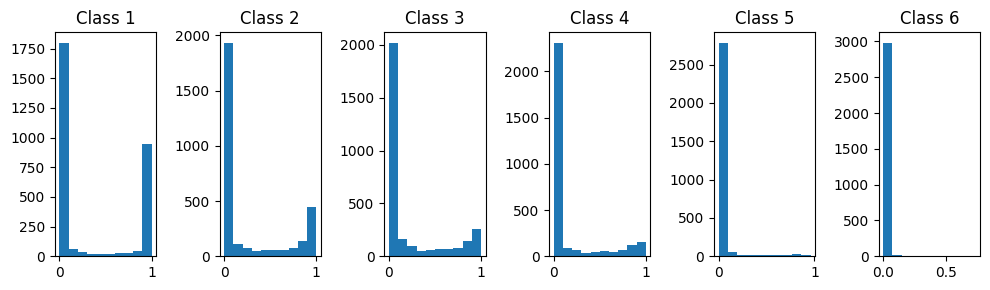

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest=RandomForestClassifier(n_estimators=100,random_state=42)
random_forest.fit(x_train,y_train_class)
random_forest_proba=random_forest.predict_proba(x_test)

plt.figure(figsize=(10,3))
for i in range(n_bins):
    plt.subplot(1,n_bins,i+1)
    plt.hist(random_forest_proba[:,i],bins=10)
    plt.title(f'Class {i+1}')
plt.tight_layout()
plt.show()

There is high probability that model is overfitted based on really certain choise of model.

## Converting Accuracy into MAE and otherwise

In [ ]:
decision_tree=DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train,y_train_class)
best_pred=decision_tree.predict(x_test)
classification_results(best_pred,y_test_class,'tree')

tree
Accuracy: 0.8573
Accuracy: 0.8557
Accuracy: 0.8573
Accuracy: 0.8527
[[989  10   0   0   0   0]
 [ 78 641   6   0   0   0]
 [  0 108 487   5   0   0]
 [  0   0 120 354   3   0]
 [  0   0   0  85  94   1]
 [  0   0   0   0  12   7]]



In [ ]:
forest_model=RandomForestRegressor(n_estimators=100,random_state=42)
forest_model.fit(x_train,y_train)
forest_pred=forest_model.predict(x_test)
print(f'MAE: {mean_absolute_error(forest_pred,y_test)}{'\n'}RMSE: {root_mean_squared_error(forest_pred,y_test)}{'\n'}R2 score: {r2_score(forest_pred,y_test)}')

MAE: 1.7093599999999993
RMSE: 2.6721569564679317
R2 score: 0.9982104443416866


In [ ]:
n_bins=4
y_min,y_max=y_test.min(),y_test.max()
r=y_max-y_min
w=r/n_bins

mae=mean_absolute_error(forest_pred,y_test)
acc=accuracy_score(best_pred,y_test_class)

acc_from_mae= 1-(mae/w)
print(f'Accuracy from MAE: {acc_from_mae}')

mea_from_acc=(1-acc)*w
print(f'MAE from accuracy: {mea_from_acc}')

Accuracy from MAE: 0.9767434013605443
MAE from accuracy: 10.486000000000004


Accuracy of discretized regression predictions: 0.9797
MAE for regression after replacing discretized predictions with class means: 18.6254


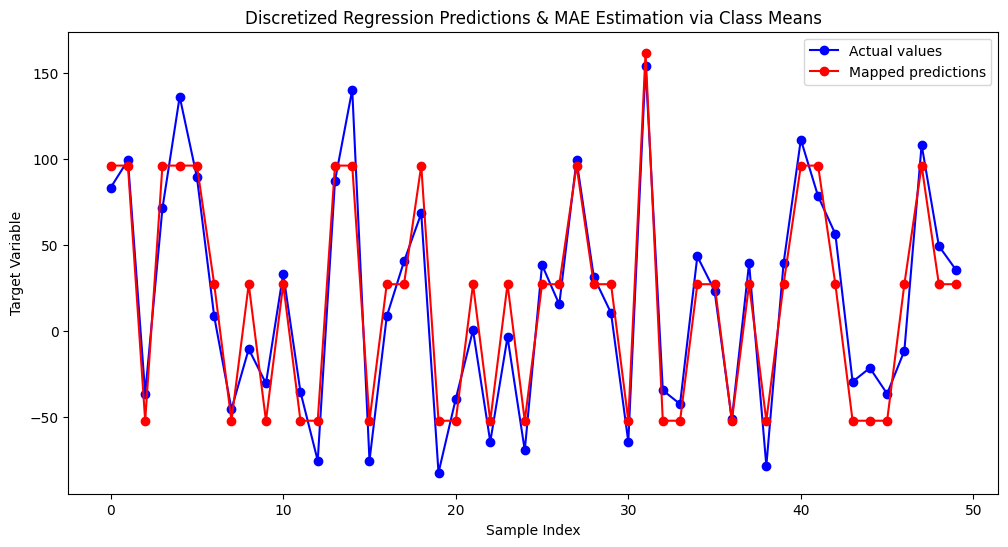

In [ ]:
predicted_classes = kbd.transform(forest_pred.reshape(-1, 1)).astype(int).ravel()
accuracy_predicted_classes = accuracy_score(y_test_class, predicted_classes)
print(f"Accuracy of discretized regression predictions: {accuracy_predicted_classes:.4f}")

class_mean_values = {}
for class_label in range(n_bins):
    class_samples = y_train[y_train_class == class_label]
    if len(class_samples) > 0:
        class_mean_values[class_label] = class_samples.mean()
    else:
        bin_edges = kbd.bin_edges_[0]
        class_mean_values[class_label] = (bin_edges[class_label] + bin_edges[class_label + 1]) / 2

mapped_predictions = np.array([class_mean_values[cls] for cls in predicted_classes])
mae_mapped_predictions = np.mean(np.abs(y_test.values - mapped_predictions))
print(f"MAE for regression after replacing discretized predictions with class means: {mae_mapped_predictions:.4f}")

plt.figure(figsize=(12, 6))
sample_indices = np.arange(50)
plt.plot(sample_indices, y_test.values[:50], 'bo-', label="Actual values")
plt.plot(sample_indices, mapped_predictions[:50], 'ro-', label="Mapped predictions")
plt.xlabel("Sample Index")
plt.ylabel("Target Variable")
plt.title("Discretized Regression Predictions & MAE Estimation via Class Means")
plt.legend()
plt.show()
